<a href="https://colab.research.google.com/github/MdAbuRummanRefat/Skin_lesions_Calssification_CNN/blob/main/Skin_Lession_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv('/content/drive/My Drive/Project/hmnist_64_64_RGB.csv')
data.head(5)

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel12249,pixel12250,pixel12251,pixel12252,pixel12253,pixel12254,pixel12255,pixel12256,pixel12257,pixel12258,pixel12259,pixel12260,pixel12261,pixel12262,pixel12263,pixel12264,pixel12265,pixel12266,pixel12267,pixel12268,pixel12269,pixel12270,pixel12271,pixel12272,pixel12273,pixel12274,pixel12275,pixel12276,pixel12277,pixel12278,pixel12279,pixel12280,pixel12281,pixel12282,pixel12283,pixel12284,pixel12285,pixel12286,pixel12287,label
0,191,152,194,191,153,195,192,149,192,194,151,188,193,149,182,193,150,181,195,154,185,195,156,189,203,164,196,206,166,203,209,165,201,211,166,206,209,165,206,203,...,202,167,183,199,159,175,189,141,148,184,131,136,180,128,136,179,127,141,176,129,149,175,127,145,179,136,157,182,146,164,185,154,180,186,156,184,182,152,173,2
1,24,13,23,24,14,28,37,24,46,61,44,70,90,66,97,111,83,118,127,98,129,144,112,141,161,131,159,169,138,165,171,135,159,173,135,156,178,138,164,178,...,176,132,147,163,121,129,143,96,96,129,89,90,111,76,74,92,60,64,69,46,56,44,27,43,30,16,34,27,14,30,26,15,29,27,15,28,24,13,25,2
2,185,129,140,192,136,151,198,142,156,198,140,154,199,141,158,199,141,159,205,147,162,205,151,167,208,154,171,207,147,161,204,146,153,207,154,161,209,156,163,210,...,199,156,175,190,147,171,194,154,183,197,152,172,175,129,140,160,117,132,163,127,141,161,128,140,161,128,144,155,122,139,152,120,138,144,113,123,115,81,84,2
3,24,11,19,36,19,30,64,38,50,91,60,71,111,71,87,130,91,106,150,114,129,160,116,124,167,110,111,168,100,101,176,110,116,184,131,144,191,141,152,191,...,154,124,138,143,111,126,129,100,111,102,74,80,94,73,86,74,47,61,52,32,45,33,17,25,28,13,19,27,13,17,27,13,16,25,12,16,24,9,14,2
4,138,94,117,158,113,138,178,133,161,191,143,172,202,150,173,212,160,185,216,162,191,222,175,209,227,183,219,229,183,216,232,188,221,234,193,222,234,191,218,235,...,221,169,202,226,167,201,226,164,197,224,176,203,224,178,206,222,181,206,213,170,191,200,155,177,187,148,164,164,128,140,140,106,118,108,77,92,67,40,55,2


In [4]:
X = data.drop("label", axis=1).values
label = data["label"].values

In [5]:
X.shape, label.shape

((10015, 12288), (10015,))

In [6]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean)/X_std

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test_temp,y_train,y_test_temp=train_test_split(X,label,test_size=0.1,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_test_temp,y_test_temp,test_size=.5,random_state=41)

In [8]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9013, 12288), (501, 12288), (9013,), (501,))

In [9]:
from keras.utils import to_categorical
def pre_processing(X,Y):
    X = X.reshape(-1,64,64,3)
    X = X/255.0
    Y = to_categorical(Y) 
    return X,Y

In [10]:
X_train,y_train=pre_processing(X_train,y_train)
X_test,y_test=pre_processing(X_test,y_test)
X_val,y_val=pre_processing(X_val,y_val)

In [11]:
X_train.shape, X_val.shape, X_test.shape,y_train.shape, y_val.shape, y_test.shape

((9013, 64, 64, 3),
 (501, 64, 64, 3),
 (501, 64, 64, 3),
 (9013, 7),
 (501, 7),
 (501, 7))

In [17]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation,Dropout, Conv2D
from keras.layers import AveragePooling2D,  MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import  Adam

In [18]:
# Our input feature map is 64x64x3: 64x64 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = Input(shape=(64, 64, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = Conv2D(16, 3, activation='relu', padding='same')(img_input)
x = MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = Dense(7, activation='softmax')(x)

# Configure and compile the model
model = Model(img_input, output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [19]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)         

In [20]:
from keras.preprocessing.image import  ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [21]:

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, 
                              factor=0.5, min_lr=0.00001)

In [22]:
batch_size = 64
epochs = 30

In [25]:
history = model.fit(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 2, steps_per_epoch=(X_train.shape[0] // batch_size),
                              callbacks=[reduce_lr])

Epoch 1/30
140/140 - 9s - loss: 0.9385 - accuracy: 0.6707 - val_loss: 0.9222 - val_accuracy: 0.6547
Epoch 2/30
140/140 - 9s - loss: 0.9103 - accuracy: 0.6740 - val_loss: 0.8987 - val_accuracy: 0.6547
Epoch 3/30
140/140 - 9s - loss: 0.8833 - accuracy: 0.6745 - val_loss: 0.8921 - val_accuracy: 0.6587
Epoch 4/30
140/140 - 9s - loss: 0.8687 - accuracy: 0.6780 - val_loss: 0.8835 - val_accuracy: 0.6627
Epoch 5/30
140/140 - 9s - loss: 0.8617 - accuracy: 0.6906 - val_loss: 0.8466 - val_accuracy: 0.6846
Epoch 6/30
140/140 - 9s - loss: 0.8477 - accuracy: 0.6918 - val_loss: 0.8523 - val_accuracy: 0.6906
Epoch 7/30
140/140 - 9s - loss: 0.8429 - accuracy: 0.6940 - val_loss: 0.8382 - val_accuracy: 0.6826
Epoch 8/30
140/140 - 9s - loss: 0.8271 - accuracy: 0.6945 - val_loss: 0.8283 - val_accuracy: 0.6886
Epoch 9/30
140/140 - 9s - loss: 0.8223 - accuracy: 0.7007 - val_loss: 0.8188 - val_accuracy: 0.6906
Epoch 10/30
140/140 - 9s - loss: 0.8159 - accuracy: 0.7019 - val_loss: 0.8376 - val_accuracy: 0.6766

In [26]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 0s 4ms/step - loss: 0.7089 - accuracy: 0.7445


[0.7088739275932312, 0.7445109486579895]

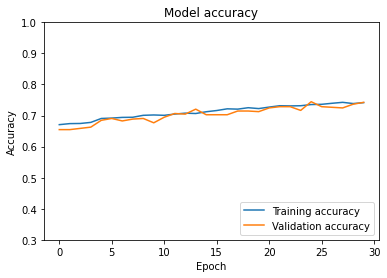

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(.3, 1.0)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [30]:

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [33]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_val, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
from sklearn.metrics import classification_report
target_names =["nv", "ml","bkl","bcc","akice","vasc","df"]
print(classification_report(y_val.argmax(axis=1),
                            predIdxs, target_names=target_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

          nv       0.50      0.26      0.34        19
          ml       0.59      0.71      0.65        28
         bkl       0.45      0.31      0.37        54
         bcc       1.00      0.17      0.29         6
       akice       0.81      0.94      0.87       330
        vasc       0.64      0.78      0.70         9
          df       0.46      0.20      0.28        55

    accuracy                           0.74       501
   macro avg       0.63      0.48      0.50       501
weighted avg       0.71      0.74      0.71       501

